In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/DL_COBAN/GAN

/content/drive/MyDrive/Colab Notebooks/DL_COBAN/GAN


In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
x_test.shape

(10000, 32, 32, 3)

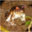

In [6]:
from PIL import Image
img = Image.fromarray(x_train[0], 'RGB')
img

In [7]:
x_train[0].shape

(32, 32, 3)

In [8]:
from tensorflow.python.eager.monitoring import Metric
from keras import optimizers
from keras.engine import sequential
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

image_dim = 32*32*3

# preprocess data
x_train = x_train.reshape(50000, image_dim)
x_test = x_test.reshape(10000, image_dim)
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

#optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

# so chieu noise vecto 
z_dim = 100

# model Generator
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(image_dim, activation='sigmoid'))
g.compile(loss='bianry_crossentropy', optimizer=adam, metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
# model discriminator
d = Sequential()
d.add(Dense(1024, input_dim=image_dim, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])

d.trainable = False

In [10]:
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss="binary_crossentropy", optimizer=adam, metrics=['acc'])

In [11]:
# draw loss function
def plot_loss(losses):
  d_loss = [v[0] for v in losses["D"]]
  g_loss = [v[0] for v in losses["G"]]

  plt.figure(figsize=(10, 8))
  plt.plot(d_loss, label='Discriminator loss')
  plt.plot(g_loss, label='Generator loss')

  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [27]:
# draw sample from generator
def plot_generator(n_ex=10, dim=(1, 10), figsize=(12, 2)):
  noise = np.random.normal(0, 1, size=(n_ex, z_dim))
  generated_images = g.predict(noise)
  generated_images = generated_images.reshape(n_ex, 32, 32, 3)

  plt.figure(figsize=figsize)
  for i in range(generated_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

Epochs: 200
Batch size: 128
Batches per epoch 390


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/200 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


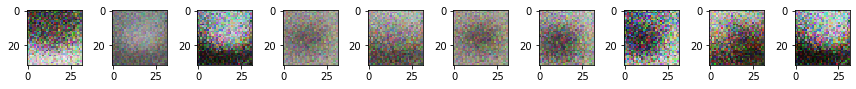

--------------- Epoch 20 ---------------


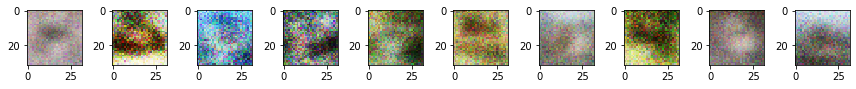

--------------- Epoch 40 ---------------


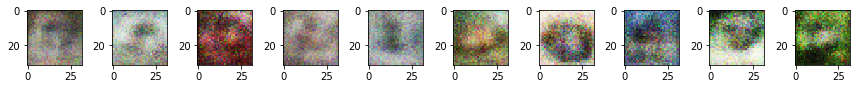

--------------- Epoch 60 ---------------


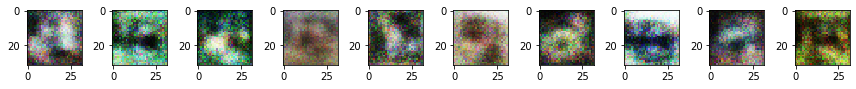

--------------- Epoch 80 ---------------


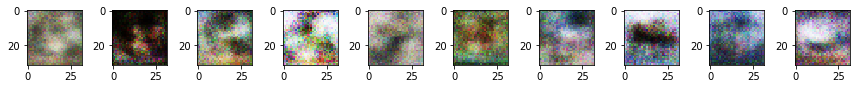

--------------- Epoch 100 ---------------


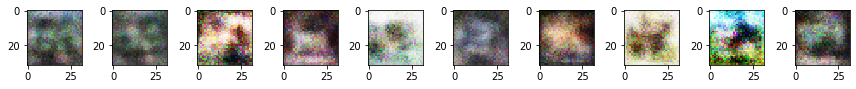

--------------- Epoch 120 ---------------


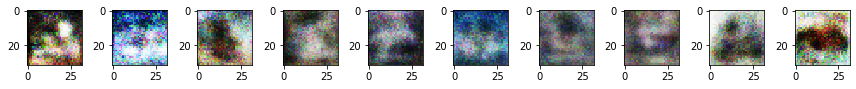

--------------- Epoch 140 ---------------


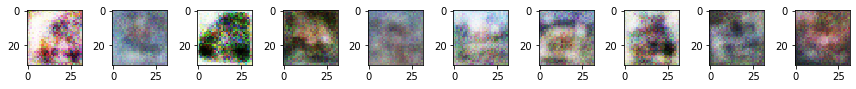

--------------- Epoch 160 ---------------


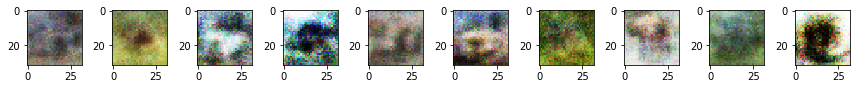

--------------- Epoch 180 ---------------


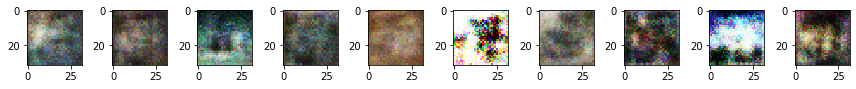

--------------- Epoch 200 ---------------


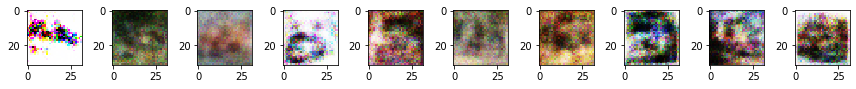

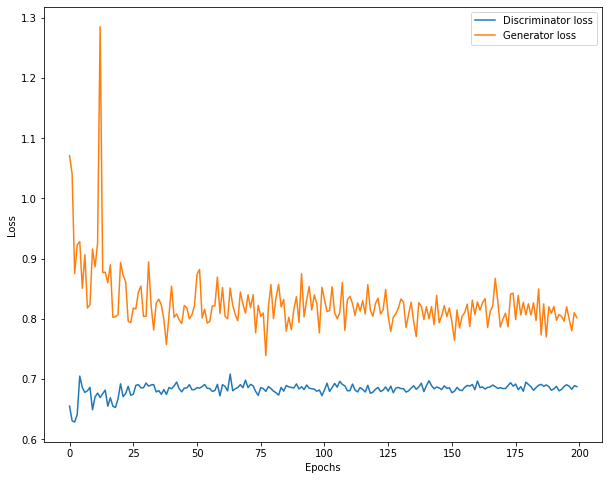

In [15]:
# loss and acc of D and G
losses = {"D": [], "G": []}
def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
  # so lan chay trong moi epochs
  batchCount = int((x_train.shape[0])/ BATCH_SIZE)
  print('Epochs:', epochs)
  print('Batch size:', BATCH_SIZE)
  print('Batches per epoch', batchCount)

  for e in tqdm_notebook(range(1, epochs+1)):
    if e == 1 or e%plt_frq == 0:
      print('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in range(batchCount):
    # Lấy ngẫu nhiên các ảnh từ MNIST dataset (ảnh thật)
      image_batch = x_train[np.random.randint(0, x_train.shape[0], size=BATCH_SIZE)]
      # Sinh ra noise ngẫu nhiên
      noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
      # Dùng Generator sinh ra ảnh từ noise
      generated_images = g.predict(noise)
      X = np.concatenate((image_batch, generated_images))
      # Tạo label
      y = np.zeros(2*BATCH_SIZE)
      y[:BATCH_SIZE] = 0.9 # gán label bằng 0.9 cho những ảnh từ MNIST dataset và 0 cho ảnh sinh ra bởi Generator
      # Train discriminator
      d.trainable = True
      d_loss = d.train_on_batch(X, y)
      # Train generator
      noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
      # Khi train Generator gán label bằng 1 cho những ảnh sinh ra bởi Generator -> cố gắng lừa Discriminator.
      y2 = np.ones(BATCH_SIZE)
      # Khi train Generator thì không cập nhật hệ số của Discriminator.
      d.trainable = False
      g_loss = gan.train_on_batch(noise, y2)
    # Lưu loss function
    losses["D"].append(d_loss)
    losses["G"].append(g_loss)
    # Vẽ các số được sinh ra để kiểm tra kết quả
    if e == 1 or e%plt_frq == 0:
      plot_generator()
  plot_loss(losses)

# Train GAN model
train(epochs=200, plt_frq=20, BATCH_SIZE=128)

In [17]:
gan.save_weights('./gan_cifa-10_weight.h5')

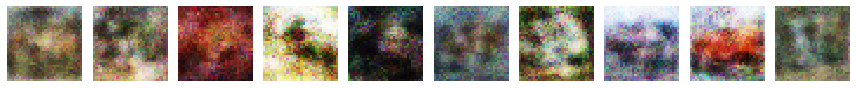

array([[0.44335002],
       [0.43665713],
       [0.4597739 ],
       [0.43518904],
       [0.44351566],
       [0.44730636],
       [0.4381869 ],
       [0.44423112],
       [0.4570485 ],
       [0.4417272 ]], dtype=float32)

In [32]:
noise = np.random.normal(0, 1, size=(10, z_dim))
generated_images = g.predict(noise)
images = generated_images.reshape(10, 32, 32, 3)

plt.figure(figsize=(12, 2))
for i in range(images.shape[0]):
  plt.subplot(1, 10, i+1)
  plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
  plt.axis('off')
plt.tight_layout()
plt.show()
d.predict(generated_images)